In [1528]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal, stats
import sys
from statsmodels.tsa.arima_model import AR
sys.path.append('../')

from nlds.data_utils import load_mouse_data, sim_lorenz
from nlds.plotting import plot_trajectory
import nlds.delayembed as de

import pyEDM as edm
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


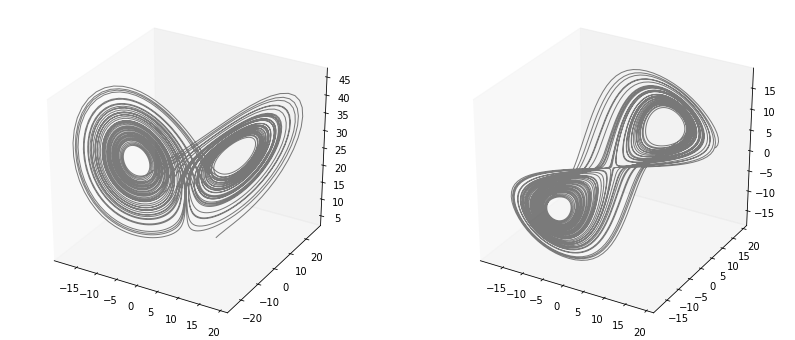

In [1215]:
T, fs = 60, 100
xinit = np.random.randint(0,10,size=3)
la = sim_lorenz(T, fs, xinit)
x_embed = de.delay_embed(la[0],10,3)
plt.figure(figsize=(14,6))
ax = plt.subplot(1,2,1, projection='3d')
plot_trajectory(np.array(la).T, ax, alpha=0.5);
ax = plt.subplot(1,2,2, projection='3d')
plot_trajectory(x_embed, ax, alpha=0.5);

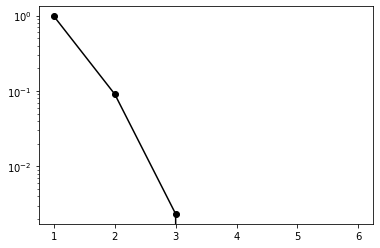

In [1221]:
tau=5
max_dim=6
dim, pfnn, del_R, rel_R = de.PFNN(la[1],tau,max_dim, return_dist=True)
plt.plot(np.arange(max_dim)+1, pfnn,'ko-', label='PFNN')
plt.yscale('log')

In [1145]:
datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'
#df_spk, df_info = load_mouse_data(datafolder, 0, return_type='smoothed', bin_width=0.1, smooth_param=[2,0.2])
df_spk, df_info = load_mouse_data(datafolder, 0, return_type='binned', bin_width=0.1)

Grabbing Spikes...
Binning Spikes...


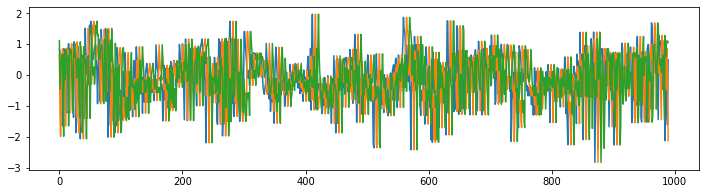

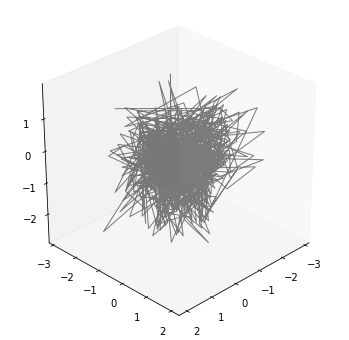

In [1228]:
pop_rate = stats.zscore(np.log10(df_spk.sum(1).values))
t = df_spk.index.values
#x_embed = de.delay_embed(np.log10(df_spk[0].values[0:10000]+1e-6),20,3)
#x_embed = de.delay_embed(df_spk[50].values[:5000],5,3)
x_embed = de.delay_embed(pop_rate[5000:6000],5,3)
plt.figure(figsize=(12,3))
plt.plot(x_embed)
plt.figure(figsize=(6,6))
ax = plot_trajectory(x_embed, step=1, alpha=0.5);
ax.view_init(elev=30., azim=45)

../nlds/delayembed.py:199: RuntimeWarning: divide by zero encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
../nlds/delayembed.py:199: RuntimeWarning: invalid value encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
../nlds/delayembed.py:199: RuntimeWarning: divide by zero encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
../nlds/delayembed.py:199: RuntimeWarning: invalid value encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]


-1


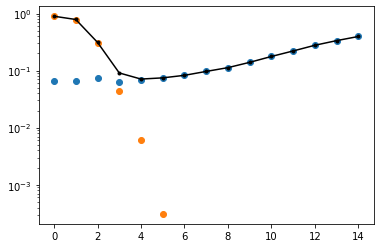

In [1229]:
tau=5
max_dim=15
x = pop_rate #pop rate
#x = np.log10(df_spk[600].values+1e-3)
dim, pfnn, del_R, rel_R = de.PFNN(x,tau,max_dim, return_dist=True)
print(dim)
plt.plot((rel_R>2).sum(0)/rel_R.shape[0], 'o', label='Distance Criteria')
plt.plot((del_R>15).sum(0)/rel_R.shape[0], 'o', label='Delta Criteria')
plt.plot(pfnn,'k.-', label='PFNN')
plt.yscale('log')

(6000,)


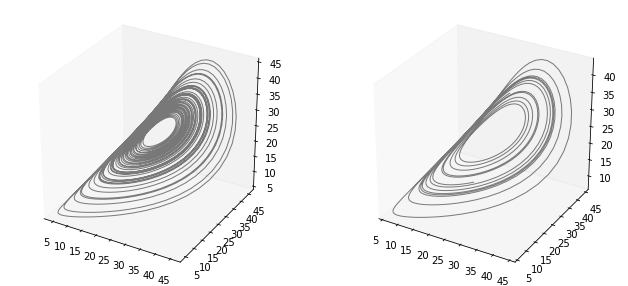

In [1477]:
#def delay_forecast(data_train, data_test, tau, max_dim=5):
#x = pop_rate
#x = np.random.randn(14000)
x = la[2]
print(x.shape)
data_train = x[:3000]
data_test = x[5000:]

tau = 5
max_dim = 10
n_neighbors = 5
n_ahead = 10

train_embed = de.delay_embed(data_train, tau, max_dim)
test_embed = de.delay_embed(data_test, tau, max_dim)

dim=3
# find knn at ith dimension
knn = NearestNeighbors(n_neighbors, algorithm='kd_tree')
knn.fit(train_embed[:-n_ahead, :dim])
dist, idx = knn.kneighbors(test_embed[:, :dim])

plt.figure(figsize=(11,5))
ax = plt.subplot(1,2,1, projection='3d')
plot_trajectory(train_embed[:,:3], ax, alpha=0.5);
ax = plt.subplot(1,2,2, projection='3d')
plot_trajectory(test_embed[:,:3], ax, alpha=0.5);

In [1478]:
test_embed[0,:dim]

array([28.70053866, 32.7031507 , 36.30540514])

In [1479]:
idx

array([[2838,  769, 2684, 2384, 2155],
       [2839, 2385, 2156, 2685,  770],
       [2840, 2157, 2386, 2312,  771],
       ...,
       [2128, 2357, 2656, 1485, 2657],
       [2129, 2358, 1486, 2657, 2658],
       [2130, 2359, 1487, 2659, 2658]])

array([21.88372087, 22.0545644 , 21.85864246, 21.96286084, 21.98444092])

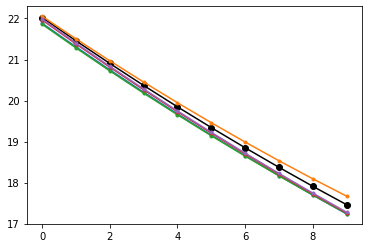

In [1480]:
test_ind = 10
plt.plot(test_embed[test_ind+np.arange(n_ahead),0],'ko-')
plt.plot(train_embed[idx[test_ind,:]+np.arange(n_ahead)[:,None],0], '.-')
# plt.plot(test_embed[test_ind+1+np.arange(n_ahead),0],'ko-')
# plt.plot(train_embed[idx[test_ind+1,:]+np.arange(n_ahead)[:,None],0], '.-')
# plt.plot(test_embed[test_ind+2+np.arange(n_ahead),0],'ko-')
# plt.plot(train_embed[idx[test_ind+2,:]+np.arange(n_ahead)[:,None],0], '.-')

train_embed[idx[test_ind,:],0]

In [1481]:
weights = np.exp(-dist/np.min(dist,1)[:,None])
pred = (weights*train_embed[idx][:,:,0]).sum(1)/weights.sum(1)
#test_embed.shape

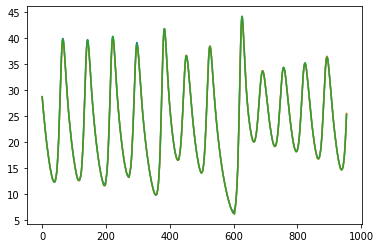

In [1484]:
# train_embed[idx+1,0]
# train_embed.shape[0]
# idx[idx>=train_embed.shape[0]-n_ahead]=np.nan
n_pred = 0
plt.plot(test_embed[n_pred:,0])
plt.plot(train_embed[idx+n_pred,0].mean(1))
plt.plot(pred)

#plt.plot(train_embed[idx+n_pred,0])
#plt.plot(train_embed[idx[0][0]:,0])
#plt.plot(train_embed[idx[0][1]:,0])
#plt.plot(train_embed[idx+n_pred,0].mean(1)[:-n_pred],test_embed[n_pred:,0])
#plt.plot(test_embed[:,0])
#idx[0][0]:
#plt.xlim([0,200])

In [1446]:
rho=[]
for n_pred in range(1,n_ahead+1):
    rho.append(stats.pearsonr(train_embed[idx+n_pred,0].mean(1)[:-n_pred],test_embed[n_pred:,0])[0])
    #rho.append(((train_embed[idx+n_pred,0].mean(1)[:-n_pred]-test_embed[n_pred:,0])**2).sum()**0.5)
plt.plot(rho,'o') 

[   8.90618592  -36.40536267   90.01317749 -149.17153933  173.20057376
 -142.71451663   82.40062037  -31.89691518    7.47137998   -0.80360376]


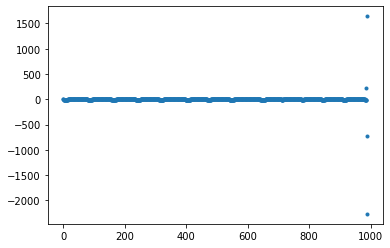

In [1565]:
maxlag=10#tau*dim
ar_model=AR(data_train)
ar_fit = ar_model.fit(maxlag, trend='nc')
print(ar_fit.params)
ar_pred = np.convolve(data_test, ar_fit.params, 'same')
plt.plot(data_test-ar_pred,'.')
# plt.plot(data_test[maxlag-1:])
# plt.plot(ar_pred)

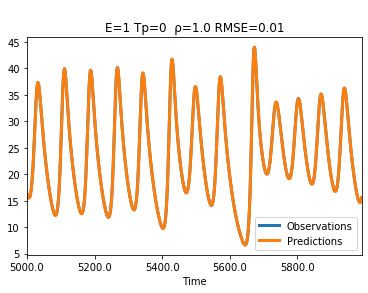

In [1487]:
df_lorenzX = pd.DataFrame(np.array([np.arange(1, len(x)+1).astype(int), x]).T, columns=['Time','X'])
#df_lorenzX = pd.DataFrame(np.array([np.arange(1, len(pop_rate)+1).astype(int), pop_rate]).T, columns=['Time','X'])
#edm.Simplex()
edm.Simplex(dataFrame = df_lorenzX, lib = "1 3000", pred = "5000 5990",  E=1, tau=tau, Tp=0, knn=5, showPlot = True, const_pred = True, columns="X", target="X");



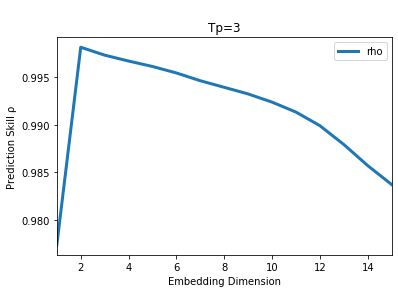

,E,rho
0,1.0,0.977390
1,2.0,0.998143
2,3.0,0.997312
3,4.0,0.996695
4,5.0,0.996122
5,6.0,0.995444
6,7.0,0.994625
7,8.0,0.993936
8,9.0,0.993239
9,10.0,0.992380


In [1472]:
edm.EmbedDimension(dataFrame = df_lorenzX, lib = "1 3000", pred = "5000 5900", columns="X", target="X", tau=5, maxE=15, Tp=3)